In [ ]:
!pip install swifter

# Machine Learning 2 
## VIX*

### Data Processing

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.dates as mdates

Download the data via Google Sheets

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Load the VIX and SPX time series

In [ ]:
ss = gc.open("DataFile")
ss

<Spreadsheet 'DataFile' id:12ilE-vzwrchXFAXh9mAYVKCWdMP64G8rskL_OGZ-niM>

In [ ]:
df = pd.DataFrame(ss.worksheet('SPX').get_all_values())
# extract the correct part of the data out
df_spx = df[6:].T.set_index(6).T.set_index('Date')['PX_LAST'].rename('SPX').apply(float)

# cast the index
df_spx.index = pd.DatetimeIndex(df_spx.index)
df = pd.DataFrame(ss.worksheet('VIX').get_all_values())
# same for VIX
df_vix = df[6:].T.set_index(6).T.set_index('Date')['PX_LAST'].rename('VIX').apply(float)
df_vix.index = pd.DatetimeIndex(df_vix.index)
df = pd.DataFrame(ss.worksheet('LIBOR').get_all_values())
# extract the correct part of the data out
df_lib = df.T[:2].T[5:].T.set_index(5).T.set_index('Date')['PX_ASK'].rename('LIBOR').apply(float)
# cast the index
df_lib.index = pd.DatetimeIndex(df_lib.index)

Pull out the 30D IVs

In [ ]:
from datetime import datetime

excel2timestamp = lambda d: pd.Timestamp(datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(d) - 2))

df = pd.DataFrame(ss.worksheet('30D').get_all_values())       # load the raw data into a frame
df = df.T.set_index(0).T      # set the column header
df = df.drop([1, 2, 3], axis=0)    # drop unnecessary columns
df['Expiry'] = df['Expiry'].apply(excel2timestamp) # convery Excel times to pd.Timestamp
df_iv30d = df = df.rename(columns={'Expiry':'30D IV'}).set_index('30D IV').applymap(float)

In [ ]:
index = df_spx.index.intersection(df_vix.index).intersection(df_vix.index).intersection(df_iv30d.index)
df_iv30d = df_iv30d.loc[index]
df_spx = df_spx.loc[index]
df_vix = df_vix.loc[index]
df_vix = df_vix.loc[index]

# use the forward for the strike
df_spx_fwd = np.exp(df_lib/1200)*df_spx

Transform to PVs

In [ ]:
strikes = [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]

In [ ]:
from scipy.stats import norm

def bsCall(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
def bsPut(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

def delta_to_strike(pc, S, delta, r, s, T):
  phi = -1 if pc == 'C' else 1
  nm1 = norm.ppf(np.abs(delta)*np.exp(r*T)) * s * np.sqrt(T)
  return S * np.exp(0.5*T*s**2 + phi*nm1)

m, n = df_iv30d.shape
pv = np.empty_like(df_iv30d)
for i in range(m):
    for j in range(n):
        pricingFnc = bsCall if df_iv30d.columns[j][0] == 'C' else bsPut
        if df_iv30d.columns[j][0] == 'A':
          strike = S=df_spx_fwd.iloc[i]
        else:
          strike = delta_to_strike(
              pc=df_iv30d.columns[j][0],
              S=df_spx_fwd.iloc[i],
              delta=abs(strikes[j])/100,
              r=df_lib.iloc[i]/100,
              s=df_iv30d.iloc[i, j]/100,
              T=1/12
          )
        pv[i, j] = pricingFnc(  S=df_spx_fwd.iloc[i], 
                                # K=df_spx_fwd.iloc[i] * strikes[j], 
                                K=strike,
                                r=df_lib.iloc[i]/100, 
                                s=df_iv30d.iloc[i, j]/100, 
                                T=1/12)            
        
df_pvs = pd.DataFrame(pv, columns=df_iv30d.columns, index=df_iv30d.index)

In [ ]:
df_pvs[['PUT10', 'PUT25', 'PUT40', 'ATM', 'CALL40', 'CALL25', 'CALL10']]

,PUT10,PUT25,PUT40,ATM,CALL40,CALL25,CALL10
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,2.133285,6.499546,11.840117,15.675499,12.597090,6.602981,2.120337
2005-01-05,2.125546,6.524659,11.993799,15.898817,12.775583,6.662345,2.127892
2005-01-06,2.061193,6.303247,11.530003,15.251375,12.368471,6.474814,2.077160
2005-01-07,1.994056,6.138579,11.315265,15.052240,12.288624,6.472456,2.089495
...,...,...,...,...,...,...,...
2021-02-24,13.285000,32.100656,51.282342,64.242533,42.102592,20.456303,6.218119
2021-02-25,18.180141,45.132819,72.886769,88.855358,55.934791,25.977342,7.375189
2021-02-26,17.921360,45.343572,73.441004,89.233723,55.965642,25.821608,7.388163
2021-03-01,14.644439,35.171885,55.491678,68.197835,44.363919,21.371084,6.493890


In [ ]:
df_strikes = pd.DataFrame(
    np.tile( np.array(strikes), (len(df_pvs), 1)), 
    index=df_pvs.index, 
    columns=df_pvs.columns
)
df_strikes = (df_strikes.T + df_spx).T

In [ ]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform((df_pvs/df_strikes**2))
df_pvs = pd.DataFrame(scaled, index=df_pvs.index, columns=df_pvs.columns)

In [ ]:
Delta = [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]
dK = [15.] + [(kp-km)/2 for kp, km in zip(Delta[2:], Delta[:-2])] + [15.]
df_vix_syn = 100*np.sqrt(2*((dK/(df_strikes**2))*pv).sum(axis='columns')*np.exp(df_lib/1200)/(1/12))
df_vix_syn = df_vix_syn.rename('VIX*')

Combine all of our data into one frame after loading. Initial data loading is now complete.

In [ ]:
df = pd.concat([df_spx.to_frame(), df_vix.to_frame(), df_lib.to_frame(), df_vix_syn.to_frame(), df_pvs], axis=1).dropna()
df = df.applymap(float) # cast everything to a float

Add in a column representing the upcoming 30D volatility of SPX. This is what we want to predict.

In [ ]:
df['30D SPX Vol'] = df['SPX'].rolling(21).std().shift(-21)
df = df.dropna()

Let's see the data we've collected

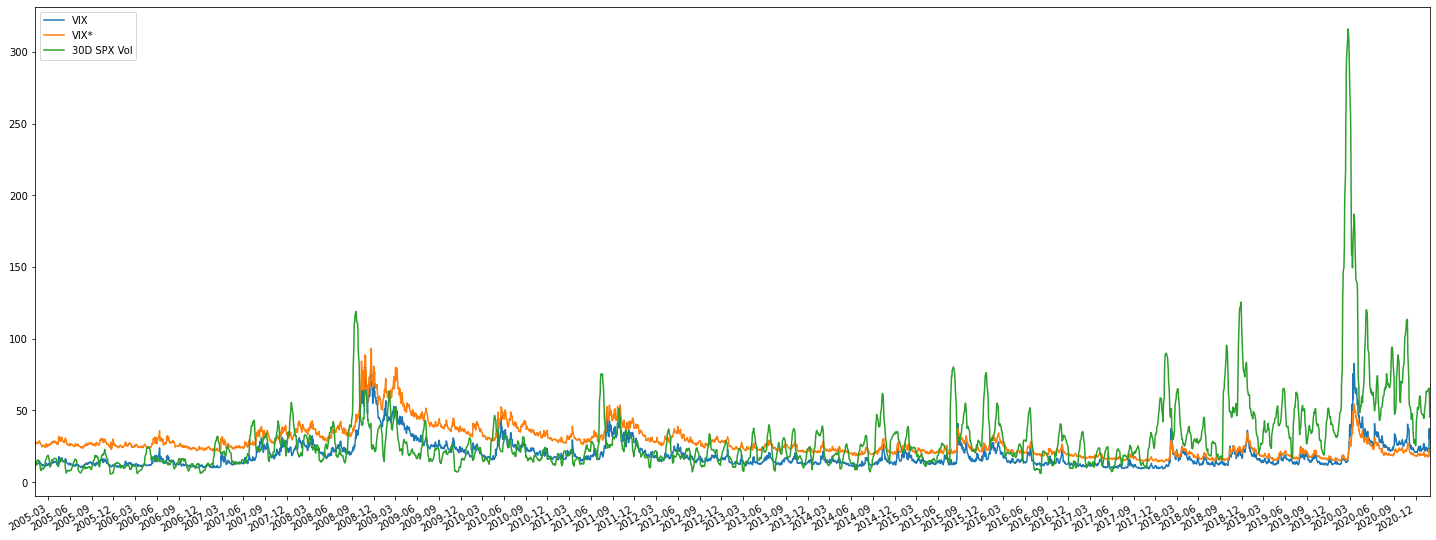

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
df[['VIX', 'VIX*', '30D SPX Vol']].plot(ax=ax)
ax.set_xlim(df.index.min(), df.index.max())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

In [ ]:
X = df['PUT90	PUT75	PUT60	PUT50	PUT40	PUT25	PUT10	ATM	CALL10	CALL25	CALL40	CALL50	CALL60	CALL75	CALL90'.split()]

Difference between VIX and SPX 30D vol

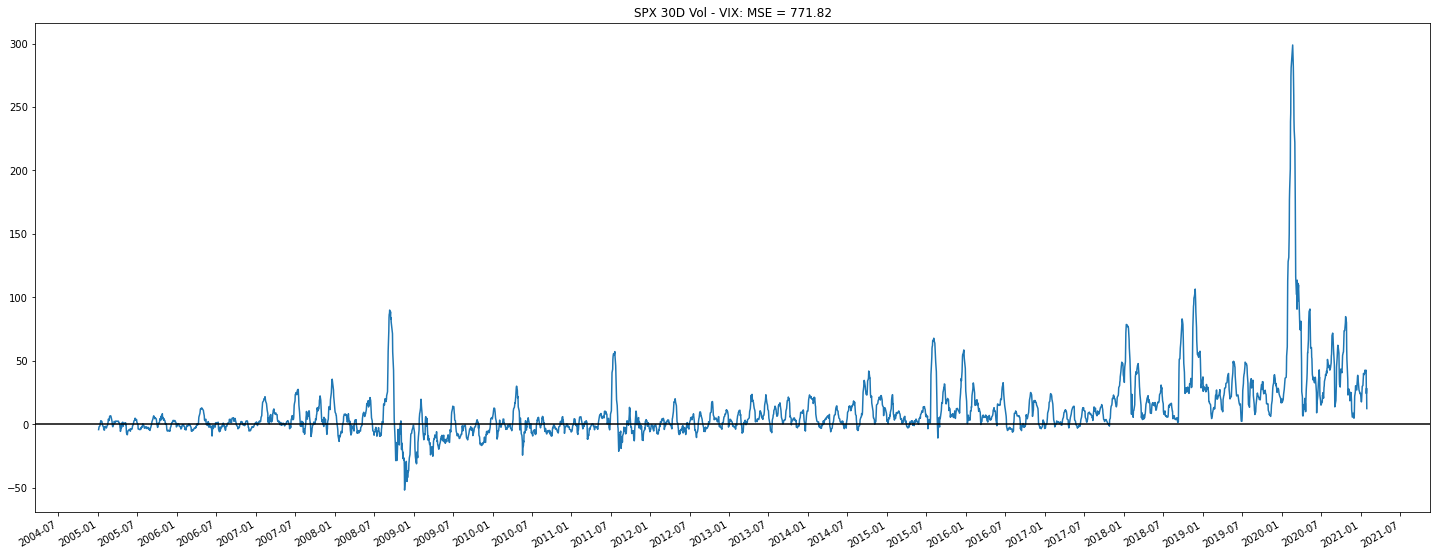

In [ ]:
import sklearn.metrics

y_vix = df['VIX']
y_true = df['30D SPX Vol']
mse = sklearn.metrics.mean_squared_error(y_true, y_vix)

title = f"SPX 30D Vol - VIX: MSE = {mse:.2f}"

fig, ax = plt.subplots(figsize=(25, 10))
(y_true - y_vix).plot(ax=ax)
ax.axhline(0, c="black")
ax.set_title(title)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

In [ ]:
df

,SPX,VIX,LIBOR,VIX*,PUT90,PUT75,PUT60,PUT50,PUT40,PUT25,PUT10,ATM,CALL10,CALL25,CALL40,CALL50,CALL60,CALL75,CALL90,30D SPX Vol
2005-01-04,1188.05,13.98,2.40000,28.108391,-0.071786,-0.025892,-0.079989,-0.116650,-0.136219,-0.182726,-0.294838,-0.112161,0.144970,0.077315,0.010145,-0.034067,-0.057931,-0.112243,-0.239097,9.662498
2005-01-05,1183.74,14.09,2.40000,28.295858,-0.065306,-0.010818,-0.060545,-0.094716,-0.119939,-0.173998,-0.292144,-0.093278,0.158421,0.096407,0.034187,-0.007108,-0.036723,-0.099789,-0.233728,10.595605
2005-01-06,1187.89,13.58,2.42000,27.717032,-0.108423,-0.047961,-0.099546,-0.134661,-0.156675,-0.205753,-0.319230,-0.135534,0.119987,0.054742,-0.010027,-0.052745,-0.079043,-0.136939,-0.266320,11.389172
2005-01-07,1186.19,13.49,2.43000,27.559686,-0.115244,-0.046062,-0.103645,-0.142286,-0.168753,-0.223117,-0.340163,-0.144216,0.130704,0.057567,-0.014122,-0.060965,-0.092448,-0.156824,-0.291156,11.531408
2005-01-10,1190.24,13.23,2.44000,27.178644,-0.133468,-0.083640,-0.133317,-0.167197,-0.191155,-0.242495,-0.356673,-0.168015,0.078417,0.014821,-0.048224,-0.089829,-0.119146,-0.180317,-0.311803,11.817205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,3855.36,23.19,0.12750,18.125236,-0.641456,-0.604562,-0.603662,-0.598512,-0.596966,-0.581070,-0.575686,-0.625927,-0.740777,-0.732698,-0.726473,-0.718557,-0.716067,-0.699338,-0.702780,65.055245
2021-01-26,3849.62,23.02,0.12250,17.966712,-0.646158,-0.608735,-0.607295,-0.602962,-0.600557,-0.586366,-0.588283,-0.631456,-0.748063,-0.738415,-0.731555,-0.724699,-0.721209,-0.706745,-0.719206,65.504603
2021-01-27,3750.77,37.21,0.12075,22.804733,-0.486768,-0.439328,-0.402249,-0.374585,-0.348163,-0.317659,-0.286273,-0.373250,-0.586415,-0.531822,-0.483885,-0.450983,-0.421680,-0.392895,-0.379432,61.294949
2021-01-28,3787.38,30.21,0.12288,20.590166,-0.561128,-0.536486,-0.515325,-0.495360,-0.477843,-0.446847,-0.420647,-0.508975,-0.679955,-0.648387,-0.617737,-0.592349,-0.571393,-0.538687,-0.523490,58.532380


In [ ]:
y_true = df['30D SPX Vol']
y_vix = df['VIX']# ** 2 - df['30D SPX Vol']

Black formula for pricing call and put ...


In [ ]:
import functools

def rolling_mse(y_true, y_pred):
  """Function which is able to calc mse, suitable for a rolling measure"""
  idx = y_true.index.intersection(y_pred.index)
  y_pred = y_pred[idx]
  y_true = y_true[idx]
  
  # calc the metric 
  return sklearn.metrics.mean_squared_error(y_true, y_pred)

Here we can see on a rolling basis VIX became a terrible indicator for 30D SPX vol from 2019 onwards



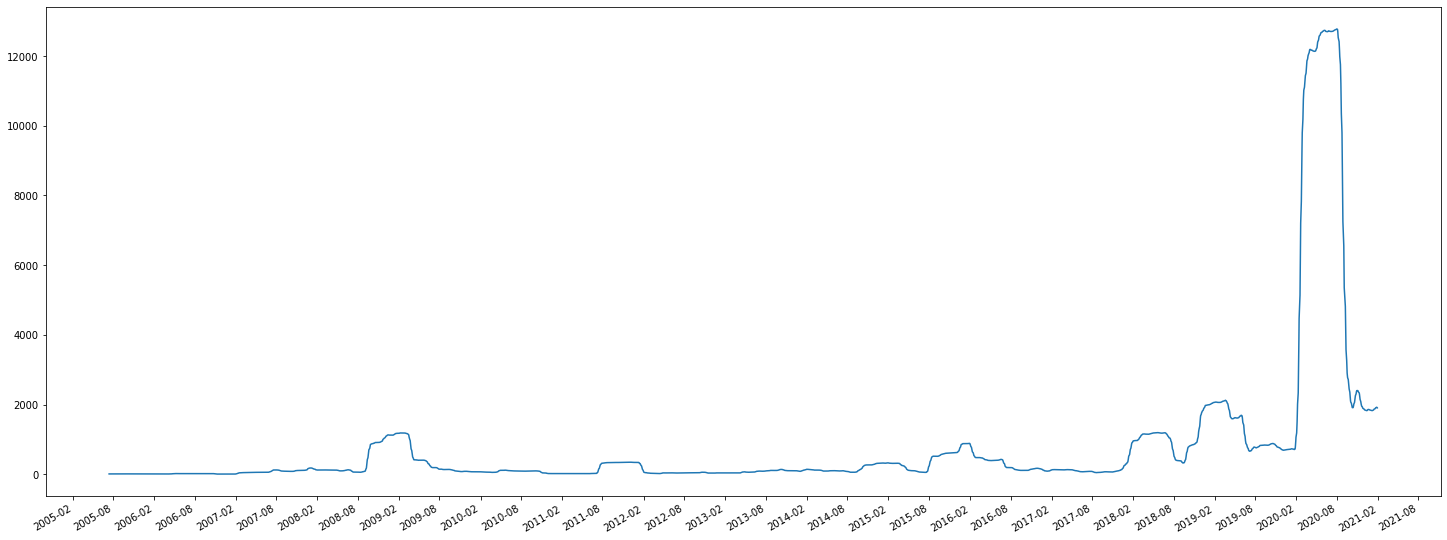

In [ ]:
mse_1yr_rolling_vix = y_true.rolling(window=21*6).apply(functools.partial(rolling_mse, y_pred=y_vix))
fig, ax = plt.subplots(figsize=(25, 10))
mse_1yr_rolling_vix.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Let's do a basic tree model

In [ ]:
def getPerformance(y_test, y_pred):
    """
    As described in Section 3.4 of the paper, we define prediction performance metrics as OOS R^2:
    
        R^2 = 1 - sum((yi-pi)^2)/ sum((yi-y_mean)^2)
        where   yi is the actual realized variance for sample i, 
                y_mean is the mean realized variance of all samples
                pi is the model predicted realized variance for sample i
    """
    numer = np.sum(np.square(y_test - y_pred))
    denom = np.sum(np.square(y_test - np.var(y_test)))
    # denom = np.sum(np.square(y_test - np.mean(y_test)))
    return 1 - numer/denom

def getMeanDecreasedAccuracy(model, X_train, X_test, y_train, y_test):
    """
    As described in Section 4.4 of the paper we use Mean-Decreased-Accuracy (MDA) to get feature importance.    
        a) one trains an algorithm on the training set using all the original features
        b) predictions are made on the test set, and a performance measure (e.g. R^2) is recorded as p0
        c) values of one of the features, i, in the test set are randomly shuffled and predictions are re-made on the test set
        d) the performance associated with the shuffled feature i is recorded as pi
    """
    # a) one trains an algorithm on the training set using all the original features
    # fit = model.fit(X_train, y_train) # already comes as fitted using all the original features
    # b) predictions are made on the test set, and a performance measure (e.g. R^2) is recorded as p0
    y_pred = model.predict(X_test)
    p0 = getPerformance(y_test, y_pred)
    mda = []
    for col in X_train.columns:
        # c) values of one of the features, i, in the test set are randomly shuffled and predictions are re-made on the test set
        X_test_shuffled = X_test.copy()
        X_test_shuffled[col] = np.random.permutation(X_test_shuffled[col].values)
        y_pred = model.predict(X_test_shuffled)
        # d) the performance associated with the shuffled feature i is recorded as pi
        pi = getPerformance(y_test, y_pred)
        mda.append(1-pi/p0)       
    return p0, mda


In [ ]:
import sklearn.ensemble
from sklearn.model_selection import TimeSeriesSplit

y_true = df['30D SPX Vol']

# this is the model
def train_test_model(X, y, model, featureAttr, title='', tscv_kwargs={}):
  """Perform training and testing for a particular model

  :return: prediction
  """
  tscv = TimeSeriesSplit(**tscv_kwargs)
  y_pred = []
  # split over a couple over time series splits
  feature_importances = []
  performance_measure = []
  for train_index, test_index in tscv.split(X):
    # separate based on train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # fit the model
    fit = model.fit(X_train, y_train)
    # perform the prediction
    _y_pred = model.predict(X_test)
    # store the prediction
    y_pred.append(pd.Series(_y_pred, index=y_test.index))
    if featureAttr.lower() == 'mda':
      p0, featureImportance = getMeanDecreasedAccuracy(model, X_train, X_test, y_train, y_test)
      performance_measure.append(p0)
      feature_importances.append(featureImportance)            
    else:
      featureImportance = getattr(model, featureAttr)
      feature_importances.append(featureImportance)    
  results = pd.concat(y_pred)
  return results, np.array(feature_importances).mean(axis=0), np.mean(performance_measure)

In [ ]:
df

,SPX,VIX,LIBOR,VIX*,PUT90,PUT75,PUT60,PUT50,PUT40,PUT25,PUT10,ATM,CALL10,CALL25,CALL40,CALL50,CALL60,CALL75,CALL90,30D SPX Vol
2005-01-04,1188.05,13.98,2.40000,28.108391,-0.071786,-0.025892,-0.079989,-0.116650,-0.136219,-0.182726,-0.294838,-0.112161,0.144970,0.077315,0.010145,-0.034067,-0.057931,-0.112243,-0.239097,9.662498
2005-01-05,1183.74,14.09,2.40000,28.295858,-0.065306,-0.010818,-0.060545,-0.094716,-0.119939,-0.173998,-0.292144,-0.093278,0.158421,0.096407,0.034187,-0.007108,-0.036723,-0.099789,-0.233728,10.595605
2005-01-06,1187.89,13.58,2.42000,27.717032,-0.108423,-0.047961,-0.099546,-0.134661,-0.156675,-0.205753,-0.319230,-0.135534,0.119987,0.054742,-0.010027,-0.052745,-0.079043,-0.136939,-0.266320,11.389172
2005-01-07,1186.19,13.49,2.43000,27.559686,-0.115244,-0.046062,-0.103645,-0.142286,-0.168753,-0.223117,-0.340163,-0.144216,0.130704,0.057567,-0.014122,-0.060965,-0.092448,-0.156824,-0.291156,11.531408
2005-01-10,1190.24,13.23,2.44000,27.178644,-0.133468,-0.083640,-0.133317,-0.167197,-0.191155,-0.242495,-0.356673,-0.168015,0.078417,0.014821,-0.048224,-0.089829,-0.119146,-0.180317,-0.311803,11.817205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,3855.36,23.19,0.12750,18.125236,-0.641456,-0.604562,-0.603662,-0.598512,-0.596966,-0.581070,-0.575686,-0.625927,-0.740777,-0.732698,-0.726473,-0.718557,-0.716067,-0.699338,-0.702780,65.055245
2021-01-26,3849.62,23.02,0.12250,17.966712,-0.646158,-0.608735,-0.607295,-0.602962,-0.600557,-0.586366,-0.588283,-0.631456,-0.748063,-0.738415,-0.731555,-0.724699,-0.721209,-0.706745,-0.719206,65.504603
2021-01-27,3750.77,37.21,0.12075,22.804733,-0.486768,-0.439328,-0.402249,-0.374585,-0.348163,-0.317659,-0.286273,-0.373250,-0.586415,-0.531822,-0.483885,-0.450983,-0.421680,-0.392895,-0.379432,61.294949
2021-01-28,3787.38,30.21,0.12288,20.590166,-0.561128,-0.536486,-0.515325,-0.495360,-0.477843,-0.446847,-0.420647,-0.508975,-0.679955,-0.648387,-0.617737,-0.592349,-0.571393,-0.538687,-0.523490,58.532380


In [ ]:
X

,PUT90,PUT75,PUT60,PUT50,PUT40,PUT25,PUT10,ATM,CALL10,CALL25,CALL40,CALL50,CALL60,CALL75,CALL90
2005-01-04,-0.071786,-0.025892,-0.079989,-0.116650,-0.136219,-0.182726,-0.294838,-0.112161,0.144970,0.077315,0.010145,-0.034067,-0.057931,-0.112243,-0.239097
2005-01-05,-0.065306,-0.010818,-0.060545,-0.094716,-0.119939,-0.173998,-0.292144,-0.093278,0.158421,0.096407,0.034187,-0.007108,-0.036723,-0.099789,-0.233728
2005-01-06,-0.108423,-0.047961,-0.099546,-0.134661,-0.156675,-0.205753,-0.319230,-0.135534,0.119987,0.054742,-0.010027,-0.052745,-0.079043,-0.136939,-0.266320
2005-01-07,-0.115244,-0.046062,-0.103645,-0.142286,-0.168753,-0.223117,-0.340163,-0.144216,0.130704,0.057567,-0.014122,-0.060965,-0.092448,-0.156824,-0.291156
2005-01-10,-0.133468,-0.083640,-0.133317,-0.167197,-0.191155,-0.242495,-0.356673,-0.168015,0.078417,0.014821,-0.048224,-0.089829,-0.119146,-0.180317,-0.311803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,-0.641456,-0.604562,-0.603662,-0.598512,-0.596966,-0.581070,-0.575686,-0.625927,-0.740777,-0.732698,-0.726473,-0.718557,-0.716067,-0.699338,-0.702780
2021-01-26,-0.646158,-0.608735,-0.607295,-0.602962,-0.600557,-0.586366,-0.588283,-0.631456,-0.748063,-0.738415,-0.731555,-0.724699,-0.721209,-0.706745,-0.719206
2021-01-27,-0.486768,-0.439328,-0.402249,-0.374585,-0.348163,-0.317659,-0.286273,-0.373250,-0.586415,-0.531822,-0.483885,-0.450983,-0.421680,-0.392895,-0.379432
2021-01-28,-0.561128,-0.536486,-0.515325,-0.495360,-0.477843,-0.446847,-0.420647,-0.508975,-0.679955,-0.648387,-0.617737,-0.592349,-0.571393,-0.538687,-0.523490


In [ ]:
initial_train_size, test_size = 1000, 30
n_splits = (len(X) - initial_train_size) // test_size
max_train_size  = len(X) - test_size
#tscv_kwargs = dict(n_splits=n_splits, test_size=test_size)
tscv_kwargs = dict(max_train_size=max_train_size, n_splits=n_splits)

tscv_kwargs = dict(n_splits=5) #TODO: Remove this line, but becomes really slow
tscv_kwargs

{'n_splits': 5}

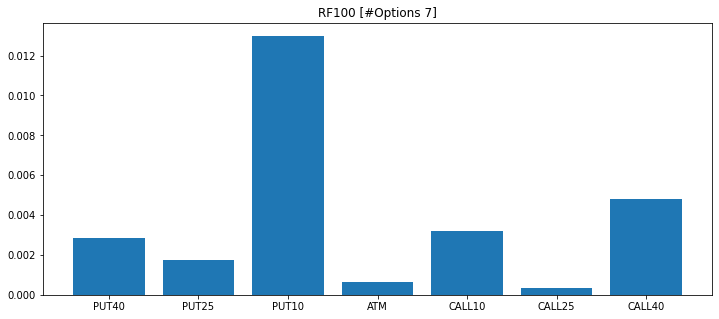

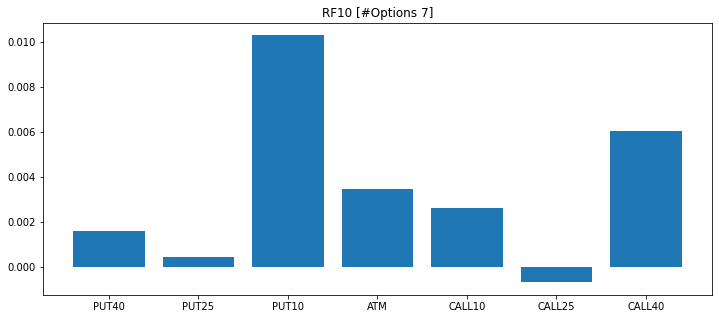

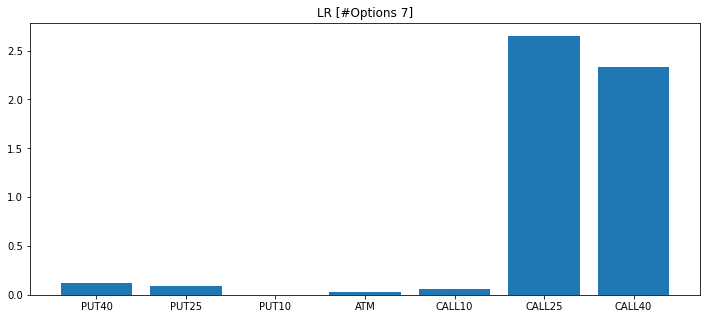

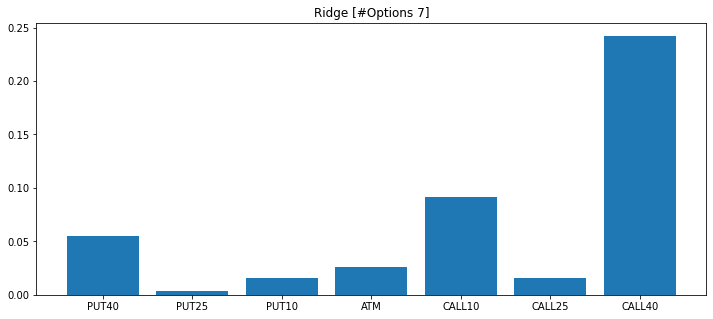

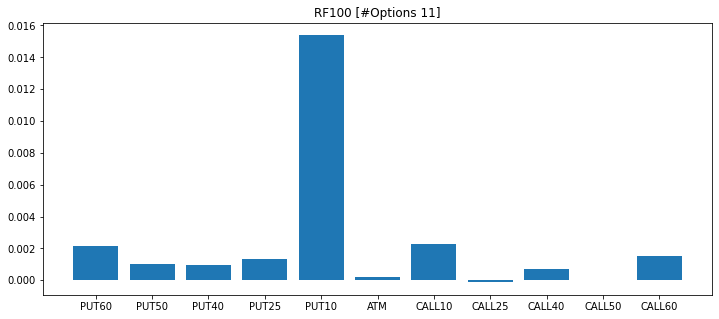

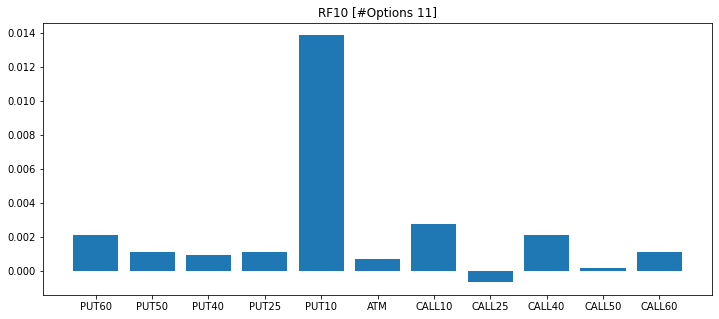

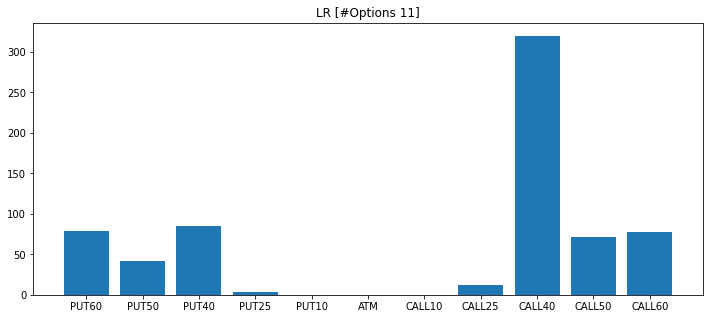

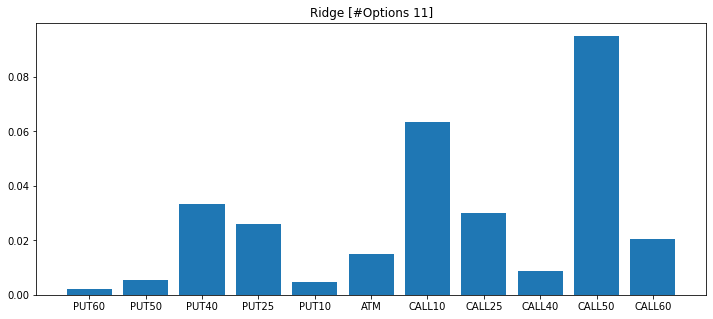

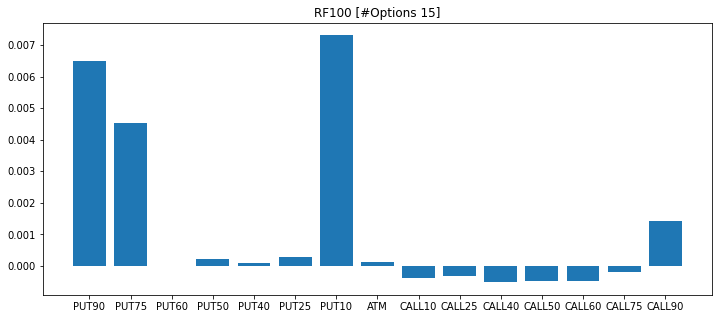

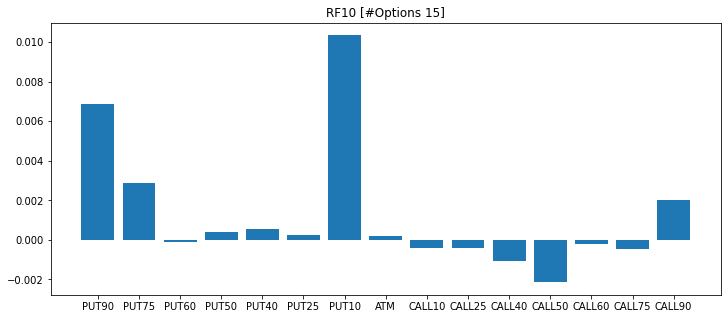

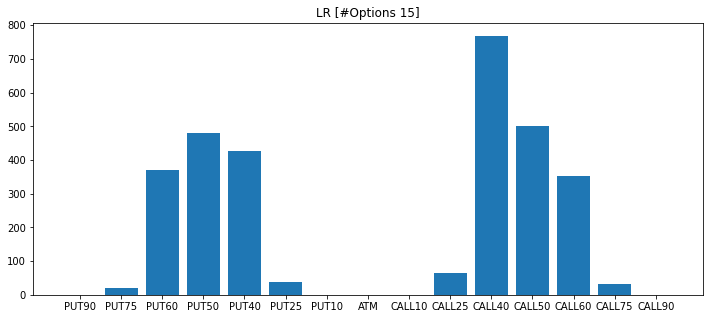

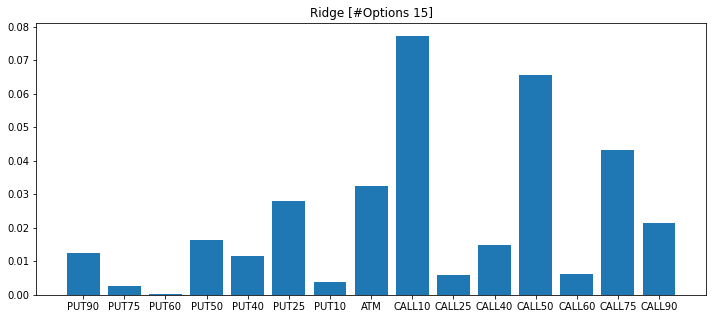

In [ ]:
models = [
  ('RF100', sklearn.ensemble.RandomForestRegressor(n_estimators=100)),
  ('RF10', sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
  ('LR', sklearn.linear_model.LinearRegression()),
  ('Ridge', sklearn.linear_model.RidgeCV()),
]

final_results = []
VIX_pre = df['VIX*']**2- df['30D SPX Vol']
VIX_nn = (VIX_pre - VIX_pre.mean())/(VIX_pre.std())
y_true = df['30D SPX Vol']
# y_true = VIX_nn

cols = list(X.columns)
idx = cols.index('ATM')
mses = []
for nOptions in [7,11,15]:
    features = X[cols[idx-nOptions//2:idx+nOptions//2+1]]
    for (title, model)  in models:
      # results, feature_importances, performance_measure = train_test_model(X, y_true, model, 'feature_importances_', title=title, tscv_kwargs=tscv_kwargs)
      results, feature_importances, performance_measure = train_test_model(features, y_true, model, 'mda', title=title, tscv_kwargs=tscv_kwargs)
      newTitle = '%s [#Options %s]' % (title, nOptions)
      mse = results.rolling(window=21*6).apply(lambda y_pred: rolling_mse(y_true=y_true, y_pred=y_pred)).rename(newTitle)
      mses.append(mse)
      final_results.append([nOptions, title, performance_measure])
      plt.figure(figsize=(12,5))
      plt.bar(features.columns, feature_importances)
      plt.title(newTitle)

In [ ]:
final_results = pd.DataFrame(final_results, columns = ['Options#', 'Model', 'R^2'])
pd.pivot_table(final_results, values='R^2', index=['Options#'], columns=['Model'], aggfunc=np.sum)


Model,LR,RF10,RF100,Ridge
Options#,,,,
7,0.991840,0.989325,0.989327,0.991999
11,0.919170,0.987761,0.989421,0.991333
15,0.929342,0.988079,0.989712,0.990529


In [ ]:
# model = sklearn.linear_model.LinearRegression()
# # results, feature_importances, performance_measure = train_test_model(X, y_true, model, 'coef_', title='LinearRegression', tscv_kwargs=tscv_kwargs)
# results, feature_importances, performance_measure = train_test_model(X, y_true, model, 'mda', title='LinearRegression', tscv_kwargs=tscv_kwargs)
# mse_logistic = results.rolling(window=21*6).apply(lambda y_pred: rolling_mse(y_true=y_true, y_pred=y_pred)).rename("Linear")
# plt.figure(figsize=(12,5))
# plt.bar(X.columns, feature_importances)

In [ ]:
# model = sklearn.linear_model.RidgeCV()
# # results, feature_importances, performance_measure = train_test_model(X, y_true, model, 'coef_', title='RidgeCV', tscv_kwargs=tscv_kwargs)
# results, feature_importances, performance_measure = train_test_model(X, y_true, model, 'mda', title='RidgeCV', tscv_kwargs=tscv_kwargs)
# mse_ridge_cv = results.rolling(window=21*6).apply(lambda y_pred: rolling_mse(y_true=y_true, y_pred=y_pred)).rename("Ridge CV")
# plt.figure(figsize=(12,5))
# plt.bar(X.columns, feature_importances)

MSE of our models vs. VIX. We see that our metric outperforms the standard VIX on a rolling basis, especially during stress periods.


Text(0.5, 1.0, 'Rolling MSE error model vs. VIX')

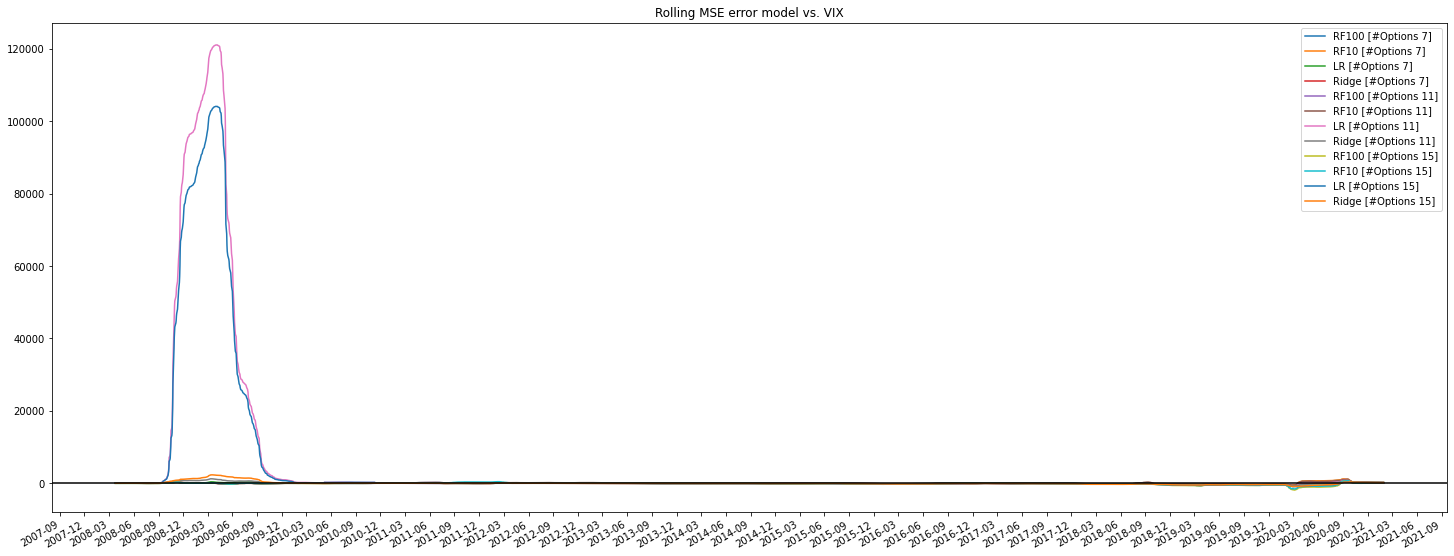

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
# MSE vs. VIX
# mses = pd.concat(rf_mses + [mse_logistic, mse_ridge_cv], axis=1)
mses = pd.concat(mses, axis=1)
mse_diffs = (mses.T - mse_1yr_rolling_vix[mses.index].values).T.dropna()
mse_diffs.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.axhline(0, c="black")
ax.set_title("Rolling MSE error model vs. VIX")

In [ ]:
mses.dropna()

,RF100 [#Options 7],RF10 [#Options 7],LR [#Options 7],Ridge [#Options 7],RF100 [#Options 11],RF10 [#Options 11],LR [#Options 11],Ridge [#Options 11],RF100 [#Options 15],RF10 [#Options 15],LR [#Options 15],Ridge [#Options 15]
2008-03-25,162.788536,154.679619,107.581093,136.027272,161.140470,164.050974,210.106708,129.128819,167.889123,177.507947,213.785476,141.087282
2008-03-26,162.835580,154.764707,107.749647,136.001218,161.170256,164.013980,211.140519,129.102354,167.897915,177.526519,214.699904,141.121636
2008-03-27,162.465653,154.440369,107.589521,135.735631,160.871161,163.395282,211.558274,128.803687,167.624494,177.280846,215.047151,140.895827
2008-03-28,161.579767,153.544161,106.951604,134.884920,159.937649,162.338313,211.605497,127.913606,166.832682,176.397257,215.107366,140.094352
2008-03-31,161.481338,153.174362,106.086361,134.229751,159.654354,162.215296,211.009630,127.062389,166.774936,176.369637,214.552893,139.218710
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,2118.764211,2139.440588,2147.830784,2127.293408,2109.878192,2059.157798,2027.537499,2098.740322,2044.936395,2040.593888,2068.367256,2059.530004
2021-01-26,2127.038995,2148.422633,2153.228355,2132.321460,2116.454841,2064.691906,2033.141612,2103.846969,2050.895823,2047.581698,2073.906714,2064.595269
2021-01-27,2119.156233,2136.699652,2150.311644,2130.002611,2107.481413,2058.365130,2032.083803,2102.551693,2040.180329,2038.121523,2071.489967,2062.504433
2021-01-28,2110.038419,2137.207754,2146.643624,2126.787227,2099.466304,2044.466676,2029.255592,2099.606984,2034.509829,2039.398654,2068.480782,2059.899330


Feedforward Neural Network Regression with ReLU Activation Function

In [ ]:
import torch
import torch.autograd
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
VIX_pre = df['VIX*']**2- df['30D SPX Vol']
VIX_nn = (VIX_pre - VIX_pre.mean())/(VIX_pre.std())
features = df[['PUT40', 'PUT25', 'PUT10', 'ATM', 'CALL10', 'CALL25', 'CALL40']]

In [ ]:
print(len(VIX_nn))

3826


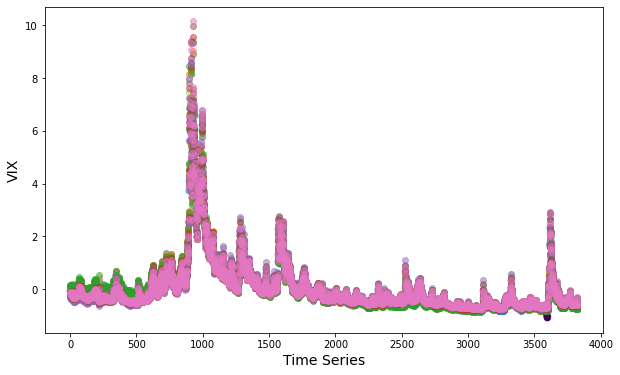

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i for i in range(len(VIX))], y = VIX,c = VIX,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['CALL40'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['CALL25'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['CALL10'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['ATM'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['PUT10'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['PUT25'].values,alpha = 0.5)
ax.scatter(x = [i for i in range(len(VIX))], y = features['PUT40'].values,alpha = 0.5)
plt.xlabel("Time Series", size = 14)
plt.ylabel("VIX", size = 14)
plt.show()

In [ ]:
X_nn = torch.Tensor(features.values[0:30])
y_nn = torch.Tensor(VIX_nn.values[0:30])

In [ ]:
# feed-forward network with linear layerr
p = 7
fc = torch.nn.Linear(p, 1, bias=False)

In [ ]:
_MSELoss = torch.nn.MSELoss()
reps = 1000
losses = np.zeros(reps)
for i in range(reps):
    fc.zero_grad()
    loss = F.mse_loss(fc(X_nn), y_nn) 
    # print(fc(X_nn))
    # print(y)
    losses[i] = loss
    loss.backward()
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad.data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


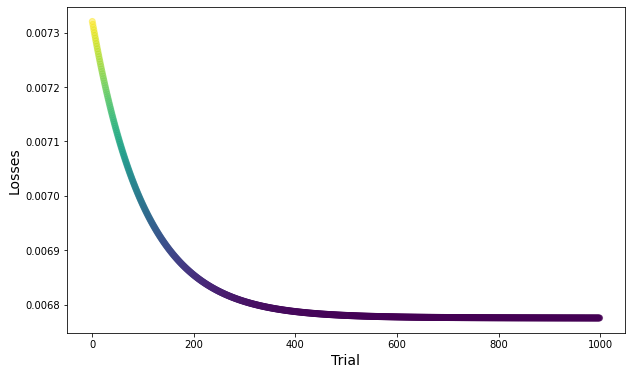

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i for i in range(reps)], y = losses,c = losses,alpha = 0.5)
plt.xlabel("Trial", size = 14)
plt.ylabel("Losses", size = 14)
plt.show()

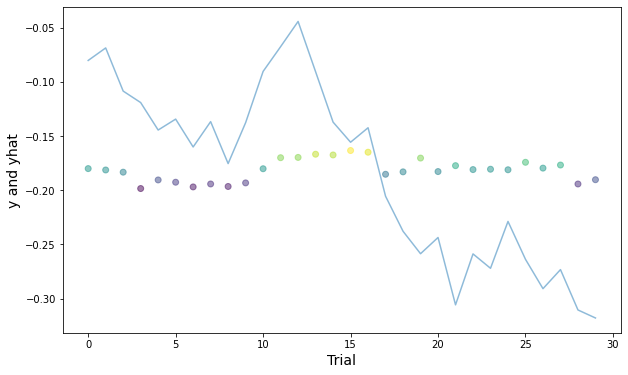

In [ ]:
# print(fc(X_nn))
yhat = [i[0] for i in fc(X_nn).detach().numpy()]
# y1 = [i for i in y.detach().numpy()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i for i in range(len(yhat))], y = yhat,c = yhat,alpha = 0.5)
ax.plot([i for i in range(len(yhat))], y_nn ,alpha = 0.5)
plt.xlabel("Trial", size = 14)
plt.ylabel("y and yhat", size = 14)
plt.show()

With ReLU

In [ ]:
class FeedforwardNeuralNetModel(torch.nn.Module):
    def __init__(self, inputD, hiddenD, outputD):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear 
        self.fc_first = torch.nn.Linear(inputD, hiddenD) 
        # Non-linear
        self.relu = torch.nn.ReLU()
        # Linear
        self.fc_second = torch.nn.Linear(hiddenD, outputD)  

    def forward(self, x):
        # Linear 
        out = self.fc_first(x)
        # Non-linear
        out = self.relu(out)
        # Linear
        out = self.fc_second(out)
        return out

In [ ]:
input_dim = 7
hidden_dim = 50
output_dim = 1

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [ ]:
reps = 1000
losses = np.zeros(reps)
MSELoss = torch.nn.MSELoss()
for i in range(reps):
    model.zero_grad()
    output = model(X_nn)
    loss = MSELoss(output,y)
    losses[i] = loss
    loss.backward()

    for param in model.parameters():
        param.data.add_(-0.1 * param.grad.data)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([3826])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


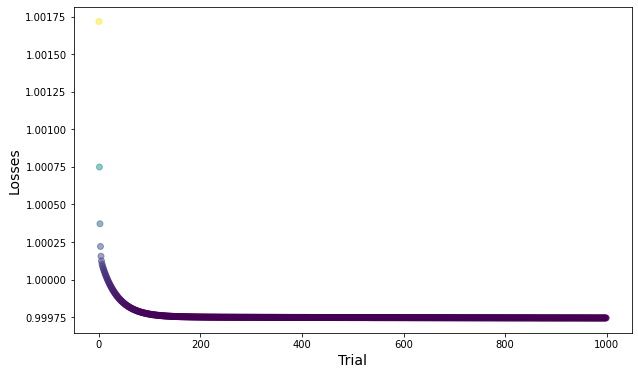

param: Parameter containing:
tensor([-0.0669], requires_grad=True)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i for i in range(reps)], y = losses,c = losses,alpha = 0.5)
plt.xlabel("Trial", size = 14)
plt.ylabel("Losses", size = 14)
plt.show()

print('param: {0}'.format(param))

tensor([[ 1.9903e-03],
        [ 3.6885e-03],
        [ 7.0064e-04],
        [ 1.4723e-03],
        [ 9.3654e-06],
        [-3.8882e-04],
        [-2.5833e-04],
        [ 1.2187e-03],
        [-1.0910e-03],
        [-2.6476e-04],
        [ 1.4546e-03],
        [ 1.3314e-03],
        [ 3.0588e-03],
        [-7.3844e-04],
        [-4.3790e-03],
        [-6.4279e-03],
        [-4.8285e-03],
        [-1.8672e-03],
        [-1.8895e-03],
        [-9.4771e-05],
        [-1.9739e-03],
        [ 2.8799e-03],
        [-2.6284e-03],
        [-9.2234e-04],
        [-1.2746e-04],
        [ 5.5793e-04],
        [ 1.7121e-03],
        [ 1.9918e-04],
        [ 3.0733e-03],
        [ 4.4556e-03]], grad_fn=<AddmmBackward>)


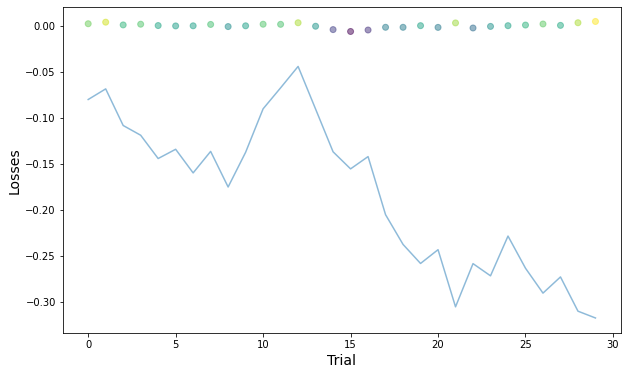

In [ ]:
print(model(X_nn))
yhat = [i[0] for i in model(X_nn).detach().numpy()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [i for i in range(len(yhat))], y = yhat,c = yhat,alpha = 0.5)
ax.plot([i for i in range(len(yhat))], y_nn ,alpha = 0.5)
plt.xlabel("Trial", size = 14)
plt.ylabel("Losses", size = 14)
plt.show()